In [3]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp 
import numpy as np
from scipy import stats

In [7]:
deg = pd.read_csv('/Users/bamudamaris/Library/CloudStorage/GoogleDrive-fufordamaris@gmail.com/My Drive/Data/Datasets/deseqoutput_protein-ids.tsv', sep = '\t', index_col = 0).T
deg.head(3)

gene-id,cds-NP_414543.1,cds-NP_414544.1,cds-NP_414545.1,cds-NP_414546.1,cds-NP_414547.1,cds-NP_414548.1,cds-NP_414549.1,cds-NP_414550.1,cds-NP_414551.1,cds-NP_414552.1,...,cds-NP_418811.2,cds-NP_418812.1,cds-NP_418813.1,cds-NP_418814.1,cds-NP_418815.1,cds-NP_418816.1,cds-NP_418817.1,cds-NP_418818.1,cds-NP_418819.1,cds-NP_418820.1
NT12189,-1.396155,-1.086905,-1.036221,-1.127845,-0.170443,0.154180,0.743706,0.231421,-1.702605,2.666265,...,-0.026376,0.058862,0.081481,0.324293,0.111350,0.357424,3.099915,0.239958,0.529843,0.288563
NT12177,-2.021794,-1.487570,-1.481607,-0.445211,0.236060,-0.659636,-0.199121,0.661353,-0.481898,0.949621,...,-0.682059,-0.349514,-0.762992,-0.336101,-0.088115,0.407631,0.086031,0.108566,0.537271,0.573327
NT12130,-0.956499,-0.586719,-0.499014,-1.345601,0.244311,-0.234788,0.440232,0.620264,-1.095199,0.796310,...,0.574220,0.061330,-0.116296,0.051911,0.330066,0.430785,-0.603411,0.244223,-0.138190,0.107360


In [8]:
strains = pd.read_csv('/Users/bamudamaris/Library/CloudStorage/GoogleDrive-fufordamaris@gmail.com/My Drive/Data/Datasets/mystrains.tsv', sep = '\t', index_col = 0)
strains.head(2)

,Strain name,Evolution Experiment?,Parental Strain,Alternative Strain Name,Full Strain Name After Genome Analysis,ENA Accession,Alternative Genome Source,Reference (PMID),Isolation origin,Year,Phenotype,German BSL level,Notes
Strain Identifier,,,,,,,,,,,,,
NT12447,B367,0,NaN,KC329,Escherichia coli B367,NaN,Broad institute Antibiotic resistance collection,NaN,Australian magpie Coffs,2001,Commensal strain,1.0,NaN
NT12619,S17,0,NaN,NaN,Escherichia coli S17,PRJNA189395,NaN,23516222,Broiler chick with septicemia,2013,Pathogenic strain,2.0,APEC


In [6]:
path = 'tested_patterns/'
full_table = None

for gene in os.listdir(path):
    if gene.startswith('cds'):
        name = gene.split('-')[1]
        name = 'cds-' + name
        
        #get hashed-patterns used in association analysis
        association = pd.read_csv(path + gene, sep = '\t', index_col = 0, names = ['variant', 'lrt-pvalue', 'beta', 'k-samples', 'nk-samples'])
       
        #get the representative kmer for the hased pattern
        hashes = pd.read_csv('/Users/fufordamaris/Desktop/My_Data/new-analysis/ecoli/panfeed-renamed-fixed/' + name + '/kmers_to_hashes.tsv.gz', compression = 'gzip', sep = '\t', index_col = 2)
    
        kmers = pd.read_csv('/Users/fufordamaris/Desktop/My_Data/new-analysis/ecoli/panfeed-renamed-fixed/' + name + '/kmers.tsv.gz', compression = 'gzip', sep = '\t').set_index('k-mer')
        kmers['strain'] = [k.split('_')[0] for k in kmers['strain']] # rename strains so they match those in the deg, and strain file for downstream analysis
        
        p = pd.merge(association, hashes, left_index = True, right_index = True, how = 'inner')
        
        p2 = kmers[kmers.index.isin(p['k-mer'])]
        
        #get predicted transcription rates for each gene kmer and strain
        file = name + '.tsv.gz'
        rates_files = '/Users/fufordamaris/Desktop/My_Data/new-analysis/model/ecoli/tx-panfeed_230/'
        if file in os.listdir(rates_files):
            rates = pd.read_csv(rates_files + file , sep = '\t', compression = 'gzip')
            rates['strain'] = [r.split('_')[0] for r in rates.strain]
            pr = pd.merge(p2, rates, on = 'strain', how = 'inner')

            #select kmer that position is closest to the position of the predicted promoter and predicted tx_rate
            pr['diff_start'] = pr['contig_start'] - pr['start']
            pr['diff_end'] = pr['contig_end'] - pr['end']

            #Group by 'strain' and deduce the minimum difference between kmers's start/end position and and that of the predicted promoter's start/end position, and then get the maximum predicted tx_rate
            #this will return only tx_rates for strains that contain the gene kmer
            tx = pr.groupby('strain').agg({ 'diff_start': 'min',
                                           'diff_end': 'min',
                                           'Tx_rate': 'max'}).reset_index()
            tx = tx[['strain', 'Tx_rate']]

            #get gene's predicted transcription rate for strains not present tx

            tx2 = rates[~rates.strain.isin(tx.strain)]
            tx2 = tx2.groupby('strain')['Tx_rate'].max().reset_index()
            tx2 = tx2[['strain', 'Tx_rate']]

            #merge the two dataframes to get one single dataframe
            tx_r = pd.concat([tx, tx2]).rename(columns = {'Tx_rate' : gene.split('.tsv')[0]})

            # if tx_r.empty:
            #     continue

            if full_table is None:
                full_table = tx_r
            else:
                full_table = pd.merge(full_table, tx_r, on='strain', how='outer')
#full_table.to_csv('tx_rates_panfeed_230.tsv',  sep = '\t', index = False)
full_table       


,strain,cds-NP_418030.1-793,cds-NP_417082.1-613,cds-NP_415117.2-501,cds-NP_416726.1-2615,cds-NP_417082.1-607,cds-NP_416801.2-1017,cds-NP_416770.1-4,cds-YP_026226.4-1448,cds-NP_416607.1-2059,...,cds-NP_415537.1-3644,cds-NP_416607.1-2068,cds-NP_416669.1-882,cds-YP_588463.1-2320,cds-NP_415708.1-3261,cds-NP_415592.1-4200,cds-NP_415129.1-35,cds-NP_415592.1-4214,cds-NP_416770.1-9,cds-NP_416834.1-4027
0,NT12001,2461.616157,13023.185487,12976.030829,1166.672266,13023.185487,2603.708627,3025.464313,1518.174637,1989.463318,...,1929.166732,1989.463318,1789.871250,2922.763810,2472.972260,1056.406243,3780.695182,1056.406243,3025.464313,2472.846772
1,NT12002,2461.616157,13023.185487,12976.030829,1166.672266,13023.185487,2603.708627,3025.464313,1518.174637,1989.463318,...,1929.166732,1989.463318,1789.871250,2922.763810,2472.972260,1056.406243,3780.695182,1056.406243,3025.464313,2472.846772
2,NT12004,2461.616157,13023.185487,12976.030829,1166.672266,13023.185487,2603.708627,3025.464313,1518.174637,1989.463318,...,1929.166732,1989.463318,1789.871250,2922.763810,2472.972260,1056.406243,3780.695182,1056.406243,3025.464313,2472.846772
3,NT12012,2461.616157,3000.928338,12976.030829,1166.672266,3000.928338,2651.387448,3025.464313,1677.181399,1989.463318,...,1929.166732,1989.463318,2078.272431,NaN,2472.972260,1056.406243,3780.695182,1056.406243,3025.464313,2472.846772
4,NT12015,2461.616157,3132.884198,12976.030829,NaN,3132.884198,2699.960566,3025.464313,1518.174637,1898.736786,...,1929.166732,1898.736786,2074.629602,NaN,2472.972260,1056.406243,3780.695182,1056.406243,3025.464313,2472.846772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,NT12460,2283.165598,4223.525815,12976.030829,1166.592948,4223.525815,2743.978833,1613.648944,1518.174637,2806.113701,...,1846.500268,2806.113701,2078.272431,NaN,2512.953531,1171.587858,3441.374804,1171.587858,1613.648944,2472.846772
113,NT12533,3771.499213,3684.816251,12976.030829,1166.672266,3684.816251,2743.978833,1663.957144,1518.174637,2851.480967,...,1846.500268,2851.480967,2078.272431,3673.059652,2575.729013,1171.587858,3538.134647,1171.587858,1663.957144,2472.846772
114,NT12552,3771.499213,4061.321551,12976.030829,1166.672266,4061.321551,2699.960566,1663.957144,1518.174637,2851.480967,...,1846.500268,2851.480967,2078.272431,NaN,2512.953531,1171.587858,4338.663347,1171.587858,1663.957144,2472.846772
115,NT12564,2610.289355,3547.091838,12976.030829,1446.183168,3547.091838,2614.730877,3025.464313,1518.174637,2077.672606,...,2386.595383,2077.672606,2175.242841,4364.725987,2512.635765,1095.092977,3627.096143,1095.092977,3025.464313,4034.390926


In [3]:
tx_rates = pd.read_csv('tx_rates_panfeed_230.tsv', sep = '\t', index_col = 0)

In [5]:
#correlation between log2Foldchange and predicted transcription rates 
#tx_rates of each divided by that of k12 and then log2 transformed.

#tx_rates = full_table.set_index('strain')
data_new = np.log2(tx_rates/tx_rates.loc['NT12001'])

#compute correlation between predicted tx_rates and actual gene expression 

pearson = {}
spearman = {}
regress = {}
rates = {}

for var in data_new.columns:
    g_var = 'cds-' + var.split('-')[1]
    rates[var] = data_new[var]
    if g_var in deg.columns:
        d = pd.merge(data_new[var], deg[g_var], left_index = True, right_index = True, how = 'inner').dropna()
        d.columns.values[1] = 'log2foldchange'
        d.columns.values[0] = 'Predicted transcription rate'

        p, pp = sp.stats.pearsonr(d['Predicted transcription rate'], d['log2foldchange'])
        pearson[var] = round(p,2), pp

        s, ps = sp.stats.spearmanr(d['Predicted transcription rate'], d['log2foldchange'])
        spearman[var] = round(s,2), ps
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(d['Predicted transcription rate'], d['log2foldchange'])
        regress[var] = [round(r_value,2),( p_value)]
        
        #create a scatter plot with hue dependent on the outcome column, and a correlation line
        plt.rcParams.update({'font.size': 16})
        plt.figure(figsize= (5,4))
        sns.lmplot(data=d, x='Predicted transcription rate', y='log2foldchange')#, hue='outcome', truncate=False, line_kws={'color': 'red'})
        plt.ylabel('log2foldchange')
        plt.xlabel('predicted tx-rate')
        plt.title(f"{g_var}     r={p:.2f}")
        plt.tight_layout()
        plt.savefig('corr-plots/' + var + '.svg', dpi = 300)
        plt.clf()

/var/folders/ys/t0s5987940jf4x94c3v464w00000gn/T/ipykernel_2704/1742925567.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize= (5,4))
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/usr/local/Cellar/jupyterlab/3.2.8/libexec/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWar

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [6]:
#save computed correlation values to dataframe for downstream analysis
data_p = pd.DataFrame(pearson).T.rename(columns = {0: 'pearson', 1: 'pearson(p-value)'})
data_sp = pd.DataFrame(spearman).T.rename(columns = {0:'spearman', 1:'spearman(p-value)'})
linregress = pd.DataFrame(regress).T.rename(columns = {0: 'r_value', 1: 'regress(p-value)'})    

In [5]:
outcomes = {}
for i in tx_rates.columns:
    name = i + '.tsv'
    a = pd.read_csv('tested_patterns/' + name,  sep = '\t', index_col = 0, names = ['pattern', 'lrt-pvalue', 'beta', 'k-samples'])
    a['assigned'] = a['lrt-pvalue'].apply(lambda x: 1 if x <= 6.95E-06 else 0)
    outcomes[i] = a['assigned'].values.tolist()
outcome = pd.DataFrame(outcomes).T.rename(columns = {0: 'association'}) 
outcome

,association
cds-NP_418030.1-793,0
cds-NP_417082.1-613,0
cds-NP_415117.2-501,0
cds-NP_416726.1-2615,0
cds-NP_417082.1-607,0
...,...
cds-NP_415592.1-4200,0
cds-NP_415129.1-35,0
cds-NP_415592.1-4214,0
cds-NP_416770.1-9,0


In [5]:
#combine dataframes
# prediction = pd.concat([data_p, data_sp, linregress, outcome], axis = 1).dropna()
# prediction['association'] = prediction['association'].astype(int)
prediction = pd.read_csv('asso-correlation-panfeed230-sig.tsv', sep = '\t', index_col = 0)
prediction

,pearson,pearson(p-value),spearman,spearman(p-value),r_value,regress(p-value),association,adjusted_p_values
cds-NP_414578.2-75,-0.01,8.981294e-01,0.02,8.151193e-01,-0.01,8.981294e-01,1,9.478283e-01
cds-NP_418204.2-940,-0.04,6.972647e-01,-0.04,6.448540e-01,-0.04,6.972647e-01,1,8.237597e-01
cds-NP_414880.2-2266,0.07,5.270828e-01,0.01,9.302139e-01,0.07,5.270828e-01,1,6.966887e-01
cds-NP_418208.1-940,-0.07,4.455788e-01,-0.06,5.351611e-01,-0.07,4.455788e-01,1,6.387368e-01
cds-NP_416773.1-1254,0.16,1.462598e-01,0.21,5.638126e-02,0.16,1.462598e-01,1,3.137891e-01
...,...,...,...,...,...,...,...,...
cds-NP_418085.2-2294,0.33,4.280707e-02,0.31,5.926000e-02,0.33,4.280707e-02,1,1.465319e-01
cds-NP_417610.1-1604,0.69,9.906809e-18,0.74,4.008327e-21,0.69,9.906809e-18,1,1.889370e-16
cds-NP_418554.1-1855,-0.37,6.530199e-05,-0.21,2.683375e-02,-0.37,6.530199e-05,1,4.712333e-04
cds-NP_418686.1-718,-0.04,7.416543e-01,-0.04,7.280097e-01,-0.04,7.416543e-01,1,8.488176e-01


Focus on significantly associated variants only 

In [6]:
#perform multiple test corrections

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

sig = prediction[prediction['association'] == 1]


# Perform multiple test correlation using Benjamini-Hochberg (FDR) correction
sig['adjusted_p_values'] = multipletests(sig['pearson(p-value)'], method='fdr_bh')[1]

#sig.to_csv('asso-correlation-panfeed230-sig.tsv', sep = '\t')

sig


,pearson,pearson(p-value),spearman,spearman(p-value),r_value,regress(p-value),association,adjusted_p_values
cds-NP_414578.2-75,-0.01,8.981294e-01,0.02,8.151193e-01,-0.01,8.981294e-01,1,9.478283e-01
cds-NP_418204.2-940,-0.04,6.972647e-01,-0.04,6.448540e-01,-0.04,6.972647e-01,1,8.237597e-01
cds-NP_414880.2-2266,0.07,5.270828e-01,0.01,9.302139e-01,0.07,5.270828e-01,1,6.966887e-01
cds-NP_418208.1-940,-0.07,4.455788e-01,-0.06,5.351611e-01,-0.07,4.455788e-01,1,6.387368e-01
cds-NP_416773.1-1254,0.16,1.462598e-01,0.21,5.638126e-02,0.16,1.462598e-01,1,3.137891e-01
...,...,...,...,...,...,...,...,...
cds-NP_418085.2-2294,0.33,4.280707e-02,0.31,5.926000e-02,0.33,4.280707e-02,1,1.465319e-01
cds-NP_417610.1-1604,0.69,9.906809e-18,0.74,4.008327e-21,0.69,9.906809e-18,1,1.889370e-16
cds-NP_418554.1-1855,-0.37,6.530199e-05,-0.21,2.683375e-02,-0.37,6.530199e-05,1,4.712333e-04
cds-NP_418686.1-718,-0.04,7.416543e-01,-0.04,7.280097e-01,-0.04,7.416543e-01,1,8.488176e-01


In [7]:
thresholds = [0.001,0.002, 0.003, 0.004, 0.005, 0.0001, 0.01, 0.05]  

total_var = len(sig)

for threshold in thresholds:
    significant_correlations = sig[(sig['pearson'] > 0) & (sig['adjusted_p_values'] <= threshold)]
    num_significant = len(significant_correlations)
    percentage = (num_significant / total_var) * 100
    print(f"For threshold {threshold}, number of significant correlations is: {num_significant} ({percentage:.2f}%)")


For threshold 0.001, number of significant correlations is: 22 (8.24%)
For threshold 0.002, number of significant correlations is: 22 (8.24%)
For threshold 0.003, number of significant correlations is: 25 (9.36%)
For threshold 0.004, number of significant correlations is: 25 (9.36%)
For threshold 0.005, number of significant correlations is: 25 (9.36%)
For threshold 0.0001, number of significant correlations is: 21 (7.87%)
For threshold 0.01, number of significant correlations is: 26 (9.74%)
For threshold 0.05, number of significant correlations is: 34 (12.73%)


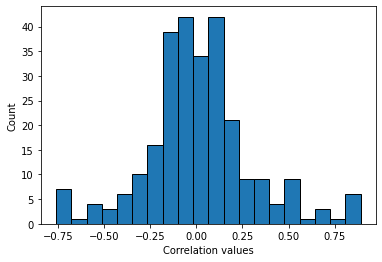

In [8]:
plt.hist(sig['pearson'], bins=20, edgecolor='black')
plt.xlabel('Correlation values')
plt.ylabel('Count')
#plt.title('Associated variants')
#plt.savefig('sig_correlation.svg', dpi = 300)
plt.show()

In [4]:
data = pd.read_csv('asso-correlation-panfeed230-sig.tsv', sep = '\t', index_col = 0)
data.head(3)

,pearson,pearson(p-value),spearman,spearman(p-value),r_value,regress(p-value),association,adjusted_p_values
cds-NP_414578.2-75,-0.01,0.898129,0.02,0.815119,-0.01,0.898129,1,0.947828
cds-NP_418204.2-940,-0.04,0.697265,-0.04,0.644854,-0.04,0.697265,1,0.823760
cds-NP_414880.2-2266,0.07,0.527083,0.01,0.930214,0.07,0.527083,1,0.696689


In [11]:
# Effect size classifications
count = data.shape[0]

# Effect size classifications with proper grouping
no_correlation = data[data['pearson'] == 0.0].shape[0]
weak = data[(data['pearson'] > 0.0) & (data['pearson'] <= 0.2) | (data['pearson'] < 0.0) & (data['pearson'] >= -0.2)].shape[0]
moderate = data[(data['pearson'] > 0.2) & (data['pearson'] < 0.8) | (data['pearson'] < -0.2) & (data['pearson'] >= -0.8)].shape[0]
strong = data[(data['pearson'] >= 0.8) | (data['pearson'] <= -0.8)].shape[0]

# Print out the classification results and proportions
print(f"No correlation (r = 0.0): {no_correlation} ({no_correlation/count*100:.2f}%)")
print(f"Weak effect (0 < r ≤ 0.2): {weak} ({weak/count*100:.2f}%)")
print(f"Moderate effect (0.2 < r < 0.8): {moderate} ({moderate/count*100:.2f}%)")
print(f"Strong effect (r ≥ 0.8): {strong} ({strong/count*100:.2f}%)")

No correlation (r = 0.0): 5 (1.87%)
Weak effect (0 < r ≤ 0.2): 175 (65.54%)
Moderate effect (0.2 < r < 0.8): 80 (29.96%)
Strong effect (r ≥ 0.8): 7 (2.62%)


In [5]:
data_filtered = data[data['adjusted_p_values'] < 0.0001]
data_filtered

,pearson,pearson(p-value),spearman,spearman(p-value),r_value,regress(p-value),association,adjusted_p_values
cds-NP_418132.1-345,-0.73,3.224524e-20,-0.72,9.821030e-20,-0.73,3.224524e-20,1,6.622676e-19
cds-NP_418132.1-347,-0.73,3.224524e-20,-0.72,9.821030e-20,-0.73,3.224524e-20,1,6.622676e-19
cds-NP_417082.1-201,0.82,7.630992e-29,0.37,3.777200e-05,0.82,7.630992e-29,1,6.460178e-27
cds-NP_418132.1-343,-0.73,3.224524e-20,-0.72,9.821030e-20,-0.73,3.224524e-20,1,6.622676e-19
cds-NP_418089.1-1541,0.81,1.451725e-28,0.72,4.044563e-20,0.81,1.451725e-28,1,6.460178e-27
cds-NP_414752.1-2591,0.51,2.604887e-07,0.58,1.193219e-09,0.51,2.604887e-07,1,2.575944e-06
cds-NP_418089.1-1527,0.81,1.451725e-28,0.72,4.044563e-20,0.81,1.451725e-28,1,6.460178e-27
cds-NP_418089.1-1533,0.81,1.451725e-28,0.72,4.044563e-20,0.81,1.451725e-28,1,6.460178e-27
cds-YP_009518818.1-1883,-0.76,3.642711e-23,-0.53,1.033072e-09,-0.76,3.642711e-23,1,9.726039e-22
cds-YP_009518818.1-1897,-0.76,3.642711e-23,-0.53,1.033072e-09,-0.76,3.642711e-23,1,9.726039e-22


In [8]:
# Effect size classifications
count = data_filtered.shape[0]

# Effect size classifications with proper grouping
no_correlation = data_filtered[data_filtered['pearson'] == 0.0].shape[0]
weak = data_filtered[(data_filtered['pearson'] > 0.0) & (data_filtered['pearson'] <= 0.2) | (data_filtered['pearson'] < 0.0) & (data_filtered['pearson'] >= -0.2)].shape[0]
moderate = data_filtered[(data_filtered['pearson'] > 0.2) & (data_filtered['pearson'] < 0.8) | (data_filtered['pearson'] < -0.2) & (data_filtered['pearson'] >= -0.8)].shape[0]
strong = data_filtered[(data_filtered['pearson'] >= 0.8) | (data_filtered['pearson'] <= -0.8)].shape[0]

# Print out the classification results and proportions
print(f"No correlation (r = 0.0): {no_correlation} ({no_correlation/count*100:.2f}%)")
print(f"Weak effect (0 < r ≤ 0.2): {weak} ({weak/count*100:.2f}%)")
print(f"Moderate effect (0.2 < r < 0.8): {moderate} ({moderate/count*100:.2f}%)")
print(f"Strong effect (r ≥ 0.8): {strong} ({strong/count*100:.2f}%)")

No correlation (r = 0.0): 0 (0.00%)
Weak effect (0 < r ≤ 0.2): 0 (0.00%)
Moderate effect (0.2 < r < 0.8): 25 (78.12%)
Strong effect (r ≥ 0.8): 7 (21.88%)


In [15]:
data_filtered.to_csv('correlated.tsv', sep = '\t')

### non-associated variants

In [27]:
non_sig = prediction[prediction['association'] == 0]


# Perform multiple test correlation using Benjamini-Hochberg (FDR) correction
non_sig['adjusted_p_values'] = multipletests(non_sig['pearson(p-value)'], method='fdr_bh')[1]
non_sig.to_csv('non-associated-correlation-panfeed230.tsv', sep = '\t')
non_sig

/var/folders/p2/bw6lvgwx47b41f63jygsccmh0000gp/T/ipykernel_1475/386022315.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_sig['adjusted_p_values'] = multipletests(non_sig['pearson(p-value)'], method='fdr_bh')[1]


,pearson,pearson(p-value),spearman,spearman(p-value),r_value,regress(p-value),association,adjusted_p_values
cds-NP_418030.1-793,0.11,2.321190e-01,0.04,6.738314e-01,0.11,2.321190e-01,0,3.866116e-01
cds-NP_417082.1-613,0.82,7.630992e-29,0.37,3.777200e-05,0.82,7.630992e-29,0,3.424221e-27
cds-NP_415117.2-501,0.04,7.029169e-01,0.11,2.330239e-01,0.04,7.029169e-01,0,8.337006e-01
cds-NP_416726.1-2615,-0.07,4.615264e-01,-0.17,7.867119e-02,-0.07,4.615264e-01,0,6.175406e-01
cds-NP_417082.1-607,0.82,7.630992e-29,0.37,3.777200e-05,0.82,7.630992e-29,0,3.424221e-27
...,...,...,...,...,...,...,...,...
cds-NP_415592.1-4200,0.05,5.947406e-01,0.07,4.285753e-01,0.05,5.947406e-01,0,7.259007e-01
cds-NP_415129.1-35,0.19,4.326332e-02,0.08,3.966438e-01,0.19,4.326332e-02,0,1.229914e-01
cds-NP_415592.1-4214,0.05,5.947406e-01,0.07,4.285753e-01,0.05,5.947406e-01,0,7.259007e-01
cds-NP_416770.1-9,0.90,1.381288e-43,0.78,8.427675e-25,0.90,1.381288e-43,0,2.039406e-41


In [16]:
thresholds = [0.001,0.002, 0.003, 0.004, 0.005, 0.0001]  

total_var = len(non_sig)

for threshold in thresholds:
    significant_correlations = non_sig[(non_sig['pearson'] > 0) & (non_sig['adjusted_p_values'] <= threshold)]
    num_significant = len(significant_correlations)
    percentage = (num_significant / total_var) * 100
    print(f"For threshold {threshold}, number of significant correlations is: {num_significant} ({percentage:.2f}%)")


For threshold 0.001, number of significant correlations is: 426 (9.31%)
For threshold 0.002, number of significant correlations is: 451 (9.85%)
For threshold 0.003, number of significant correlations is: 452 (9.88%)
For threshold 0.004, number of significant correlations is: 464 (10.14%)
For threshold 0.005, number of significant correlations is: 464 (10.14%)
For threshold 0.0001, number of significant correlations is: 370 (8.08%)


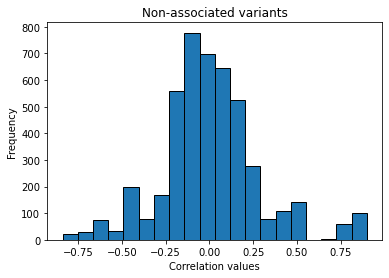

In [26]:
plt.hist(non_sig['pearson'], bins=20, edgecolor='black')
plt.xlabel('Correlation values')
plt.ylabel('Frequency')
plt.title('Non-associated variants')
plt.savefig('non-sig_correlation.png', dpi = 300)
plt.show()